In [ ]:
#fetching the data from MIT-BIH
!wget -r -N -c -np https://physionet.org/files/nstdb/1.0.0/
!wget -r -N -c -np https://physionet.org/files/mitdb/1.0.0/
!pip install wfdb

Streaming output truncated to the last 5000 lines.
--2023-06-28 05:07:03--  https://physionet.org/files/mitdb/1.0.0/223.xws
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 88 [text/plain]
Saving to: ‘physionet.org/files/mitdb/1.0.0/223.xws’

physionet.org/files 100%[===================>]      88  --.-KB/s    in 0s      

2023-06-28 05:07:03 (18.2 MB/s) - ‘physionet.org/files/mitdb/1.0.0/223.xws’ saved [88/88]

--2023-06-28 05:07:03--  https://physionet.org/files/mitdb/1.0.0/228.atr
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 5198 (5.1K) [application/octet-stream]
Saving to: ‘physionet.org/files/mitdb/1.0.0/228.atr’

physionet.org/files 100%[===================>]   5.08K  --.-KB/s    in 0s      

2023-06-28 05:07:03 (927 MB/s) - ‘physionet.org/files/mitdb/1.0.0/228.atr’ saved [5198/5198]

--2023-06-28 05:07:03--  https://physionet.org/files/mitdb/1.0.0/228.dat
Reusing ex

In [ ]:
#imports here
import wfdb
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler, normalize
from statistics import variance as var
from operator import add

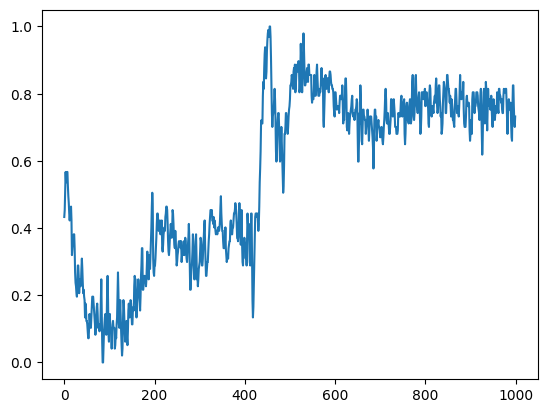

In [ ]:
#reading the muscle artifact noise and spliting it into 650 parts each of length 1000 and normalizing it
#bw contains 650000 sample points
bw,f = wfdb.rdsamp('/content/physionet.org/files/nstdb/1.0.0/bw', sampto=650000)
bw=np.array(bw)
noise=[]
v=0
for i in range(649):
  y=[]
  for k in range(1000):
    y.append(bw[v+k][0])
  z=[]
  p=max(y)
  q=min(y)
  for l in range(len(y)):
      t=(y[l]-q)/(p-q)
      z.append(t)
  noise.append(z)
  v=v+1000
plt.plot(noise[1])

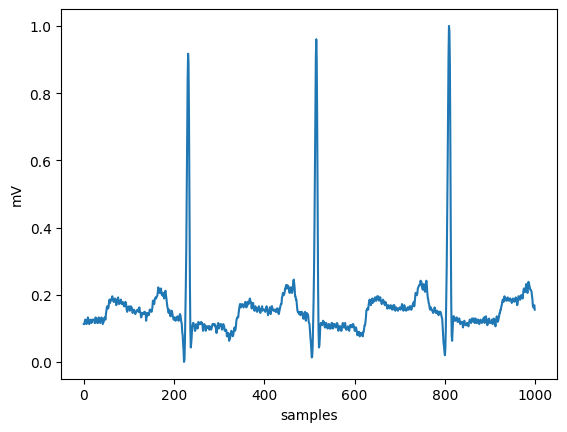

In [ ]:
# reading data spliting and normalizing it........
data=[]
rec=['100','101','102','103','104','105','106','107','108','109','111','112','113','114','115','116','117','118','119','121','122','123','124','200','201','202','203','205','207','208','209','210','212','213','214','215','217','219','220','221','222','223','228','230','231','232','233','234']

for string in rec:
  record= wfdb.rdsamp('/content/physionet.org/files/mitdb/1.0.0/'+string, sampto=650000)
  ann = wfdb.rdann('/content/physionet.org/files/mitdb/1.0.0/'+string, 'atr', sampto=650000)
  I = record[0][:, 0]
  a=0
  e=1000
  for i in range(650):
    z=[]
    d=I[a:e]
    p=max(d)
    q=min(d)
    for l in range(len(d)):
      t=(d[l]-q)/(p-q)
      z.append(t)
    data.append(z)
    a+=1000
    e+=1000
#plotting the acquired ecg signal, mind that we are only taking lead I
plt.plot(data[1])
plt.xlabel('samples')
plt.ylabel('mV')
#dividing data in train and test test samples
train_data=[]
test_data=[]
for i in range(int(len(data)*0.8)):
  train_data.append(data[i])
for j in range(int(len(data)*0.8),len(data)):
  test_data.append(data[j])

Current size: [6.4, 4.8]


Text(0, 0.5, 'mV')

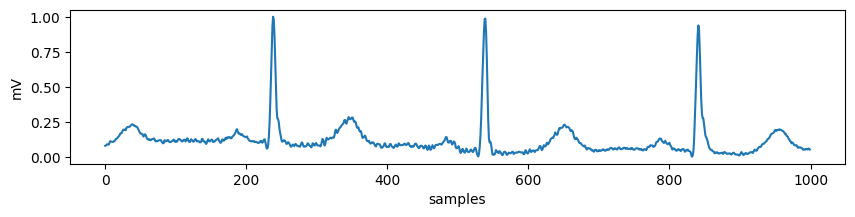

In [ ]:
fig_size = plt.rcParams["figure.figsize"]

# Prints: [8.0, 6.0]
print("Current size:", fig_size)
# Set figure width to 12 and height to 9
fig_size[0] = 10
fig_size[1] = 2
plt.rcParams["figure.figsize"] = fig_size
plt.plot(data[1000])
plt.xlabel('samples')
plt.ylabel('mV')

In [ ]:
#noise_bw_data base
import random
n=[]
n_tr=[]
n_ts=[]
noise_bw_data=[]
for i in range(31200):
  l=random.randrange(0,200)
  n.append(noise[l])
  p=list(map(add,data[i],noise[l]))
  p=np.array(p)
  noise_bw_data.append(p)
trainbw_data=[]
testbw_data=[]
for i in range(int(len(noise_bw_data)*0.8)):
  trainbw_data.append(noise_bw_data[i])
  n_tr.append(n[i])
for j in range(int(len(noise_bw_data)*0.8),len(noise_bw_data)):
  testbw_data.append(noise_bw_data[j])
  n_ts.append(n[j])

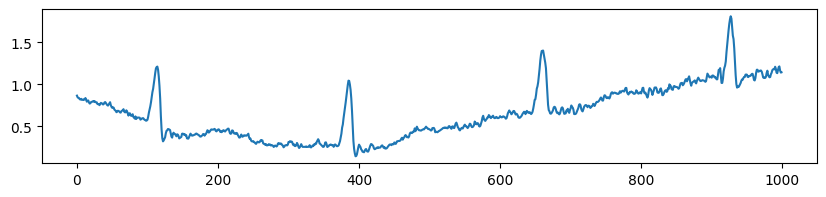

In [ ]:
plt.plot(noise_bw_data[15000])

In [ ]:

#Metrics for future implementation
#to calulate snr, rmse, max_abs_val, normalized_cross_correlation
#https://github.com/scipy/scipy/issues/9097
def urms(x):
  y=[]
  for i in range(len(x)):
    y.append(x[i]**2)
  s=sum(y)
  return s
def signaltonoise(a,b):
  a=urms(a)
  b=urms(b)
  snr=a/b
  return np.log(snr)*10
#intellipaat.com/community/1269/is-there-a-library-function-for-root-mean-square-error-rmse-in-python
def rmse(predictions, targets):
    return np.sqrt(((np.array(predictions) - np.array(targets)) ** 2).mean())
#https://stackoverflow.com/questions/44864633/pythonic-way-to-find-maximum-absolute-value-of-list
def max_abs_val(samp_list):
  max_abs_value = samp_list[0]
  for num in samp_list:
      if abs(num) > max_abs_value:
          max_abs_value = abs(num)
  return max_abs_value
#www.researchgate.net/post/How_can_one_calculate_normalized_cross_correlation_between_two_arrays
def normalized_cross_corr(x,y):
  x,y=np.array(x),np.array(y)
  N=len(x)
  a=(np.sqrt(var(x)*var(y)))
  b=(x - x.mean())* (y - y.mean())
  ncc = (1/N)*(sum(b))
  return ncc/a
def convert_numpy_tensor(arr):
  arr=np.array(arr)
  ten=torch.from_numpy(arr)
  return ten

In [ ]:
#AutoEncoder
# define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1000,500)
        self.fc2 = nn.Linear(500,250)
        self.fc3 = nn.Linear(250,100)
        self.fc4=nn.Linear(100,250)
        self.fc5=nn.Linear(250,500)
        self.fc6=nn.Linear(500,1000)
        self.dropout = nn.Dropout(0.2)
    def encoder(self, x):
        x=x.squeeze()
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x=F.relu(x)
        return x
    def decoder(self,x):
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)
        x=x.view(-1)
        return x
# initialize the NN
model = Net()
model.cuda()
print(model)
model.double()

Net(
  (fc1): Linear(in_features=1000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=250, bias=True)
  (fc3): Linear(in_features=250, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=250, bias=True)
  (fc5): Linear(in_features=250, out_features=500, bias=True)
  (fc6): Linear(in_features=500, out_features=1000, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


Net(
  (fc1): Linear(in_features=1000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=250, bias=True)
  (fc3): Linear(in_features=250, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=250, bias=True)
  (fc5): Linear(in_features=250, out_features=500, bias=True)
  (fc6): Linear(in_features=500, out_features=1000, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [ ]:
# specify loss function
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.09,momentum=0.2)
# number of epochs to train the model
n_epochs = 100
# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    model.train() # prep model for training
    for i in range(int(len(trainbw_data))):
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        b=convert_numpy_tensor(trainbw_data[i])
        b=b.cuda()
        compressed = model.encoder(b)
        output=model.decoder(compressed)
        g=convert_numpy_tensor(train_data[i])
        g=g.cuda()
        # calculate the loss
        loss = criterion(output,g.squeeze())
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*b.size(0)
    model.eval() # prep model for evaluation
    for j in range(int(len(testbw_data))):
        # forward pass: compute predicted outputs by passing inputs to the model
        c=torch.from_numpy(testbw_data[j])
        c=c.cuda()
        compressed = model.encoder(c)
        output=model.decoder(compressed)
        h=convert_numpy_tensor(test_data[j])
        h=h.cuda()
        # calculate the loss
        loss = criterion(output,h.squeeze())
        # update running validation loss
        valid_loss += loss.item()*c.size(0)
        if (j==len(test_data)-1) and (epoch==n_epochs):
            plt.plot(testbw_data[j])
            plt.plot(output.detach().numpy())

    # print training/validation statistics
    # calculate average loss over an epoch
    train_loss = train_loss/int(len(trainbw_data))
    valid_loss = valid_loss/int(len(testbw_data))

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1,
        train_loss,
        valid_loss
        ))

Epoch: 1 	Training Loss: 23.805459 	Validation Loss: 24.515624
Epoch: 2 	Training Loss: 22.897335 	Validation Loss: 23.545647
Epoch: 3 	Training Loss: 22.593832 	Validation Loss: 22.964614
Epoch: 4 	Training Loss: 21.945496 	Validation Loss: 21.994977
Epoch: 5 	Training Loss: 20.593916 	Validation Loss: 21.023735
Epoch: 6 	Training Loss: 19.338934 	Validation Loss: 20.075363
Epoch: 7 	Training Loss: 18.287507 	Validation Loss: 19.162529
Epoch: 8 	Training Loss: 17.384004 	Validation Loss: 18.478591
Epoch: 9 	Training Loss: 16.672108 	Validation Loss: 17.756082
Epoch: 10 	Training Loss: 15.996146 	Validation Loss: 17.084912
Epoch: 11 	Training Loss: 15.325654 	Validation Loss: 16.495428
Epoch: 12 	Training Loss: 14.696718 	Validation Loss: 15.983780
Epoch: 13 	Training Loss: 14.116296 	Validation Loss: 15.486438
Epoch: 14 	Training Loss: 13.597029 	Validation Loss: 15.141400
Epoch: 15 	Training Loss: 13.180885 	Validation Loss: 14.782237
Epoch: 16 	Training Loss: 12.770416 	Validation L

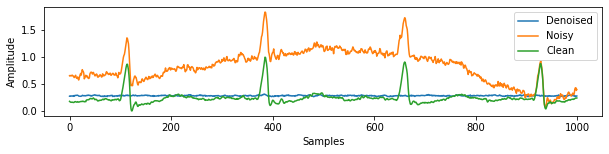

In [ ]:
#check for viz
c=torch.from_numpy(noise_bw_data[15000])
c=c.cuda()
compressed = model.encoder(c)
output=model.decoder(compressed)
output=output.detach().cpu().numpy()
plt.plot(output , label = 'Denoised')
plt.plot(noise_bw_data[15000] , label = 'Noisy')
plt.plot(data[15000] , label = 'Clean')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [ ]:
#testing
snr_original=0
snr_noise_added=0
snr_denoised=0
rootms=0
for i in range(20000,30000):
  c=torch.from_numpy(noise_bw_data[i])
  c=c.cuda()
  compressed = model.encoder(c)
  output=model.decoder(compressed)
  output=output.detach().cpu().numpy()
  d=data[i]
  snr_original=snr_original+signaltonoise(d,n[i])
  snr_noise_added=snr_noise_added+signaltonoise(noise_bw_data[i],n[i])
  snr_denoised=snr_denoised+signaltonoise(output,output-d)
  rootms=rootms+rmse(d,output)
snr_original=snr_original/10000
snr_noise_added=snr_noise_added/10000
snr_denoised=snr_denoised/10000
rootms=rootms/10000
print('snr of original signal {} db'.format(snr_original))
print('snr of noise_added signal {} db'.format(snr_noise_added))
print('snr of denoised signal {} db'.format(snr_denoised))
print('root mean square error {}'.format(rootms))

snr of original signal -11.536007325399444 db
snr of noise_added signal 8.115978134833888 db
snr of denoised signal 15.55871735039537 db
root mean square error 0.15508947919782962


In [ ]:
#store the saved model
torch.save(model.state_dict(), 'bw.pt')

In [ ]:
from google.colab import files
files.download('bw.pt')

In [ ]:
#loading the model..........
model.load_state_dict(torch.load('bw.pt'))

<All keys matched successfully>

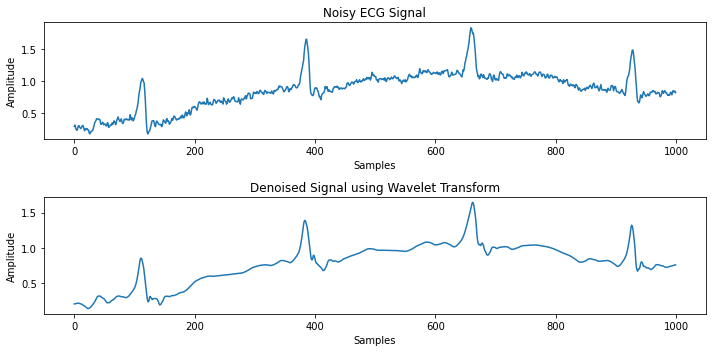

snr of original signal -11.62018682034503 db
snr of noise_added signal 8.08746942087524 db
snr of denoised signal 8.620480064125159 db
root mean square error 0.5450213476973639


In [ ]:
# Wavelet Transform
import pywt

# Define wavelet function and level of decomposition
wavelet = 'db4'
level = 4

# Denoise each signal using wavelet transform
denoised_data = []
for signal in noise_bw_data:
    # Perform wavelet decomposition
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    # Set threshold for coefficients
    sigma = np.median(np.abs(coeffs[-level])) / 0.6745
    threshold = sigma * np.sqrt(2 * np.log(len(signal)))
    # Apply soft thresholding to coefficients
    denoised_coeffs = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]
    # Reconstruct denoised signal from coefficients
    denoised_signal = pywt.waverec(denoised_coeffs, wavelet)
    denoised_data.append(denoised_signal)

import matplotlib.pyplot as plt

# Plot first signal in database
signal_index = 15000
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(noise_bw_data[signal_index])
plt.title('Noisy ECG Signal')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.subplot(2, 1, 2)
plt.plot(denoised_data[signal_index])
plt.title('Denoised Signal using Wavelet Transform')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

#testing
snr_original=0
snr_noise_added=0
snr_denoised=0
rootms=0
for i in range(20000,30000):
  output = denoised_data[i]
  d=data[i]
  snr_original=snr_original+signaltonoise(d,n[i])
  snr_noise_added=snr_noise_added+signaltonoise(noise_bw_data[i],n[i])
  snr_denoised=snr_denoised+signaltonoise(output,output-d)
  rootms=rootms+rmse(d,output)
snr_original=snr_original/10000
snr_noise_added=snr_noise_added/10000
snr_denoised=snr_denoised/10000
rootms=rootms/10000
print('snr of original signal {} db'.format(snr_original))
print('snr of noise_added signal {} db'.format(snr_noise_added))
print('snr of denoised signal {} db'.format(snr_denoised))
print('root mean square error {}'.format(rootms))

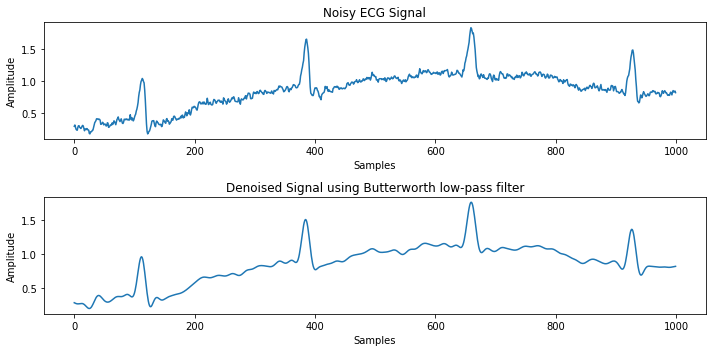

snr of original signal -11.62018682034503 db
snr of noise_added signal 8.08746942087524 db
snr of denoised signal 8.029962777362682 db
root mean square error 0.598600532747396


In [ ]:


# Butterworth low-pass filter
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

# Define Butterworth low-pass filter
cutoff = 0.1  # Cutoff frequency
order = 5  # Filter order
b, a = signal.butter(order, cutoff, btype='low', analog=False)

# Apply filter to each data point in the noisy database
denoised_signal = []
for i in range(len(noise_bw_data)):
  denoised_point = signal.filtfilt(b, a, noise_bw_data[i])
  denoised_signal.append(denoised_point)

# Plot the first data point in the noisy and denoised databases
signal_index = 15000
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(noise_bw_data[signal_index])
plt.title('Noisy ECG Signal')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.subplot(2, 1, 2)
plt.plot(denoised_signal[signal_index])
plt.title('Denoised Signal using Butterworth low-pass filter')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

#testing
snr_original=0
snr_noise_added=0
snr_denoised=0
rootms=0
for i in range(20000,30000):
  output = denoised_signal[i]
  d=data[i]
  snr_original=snr_original+signaltonoise(d,n[i])
  snr_noise_added=snr_noise_added+signaltonoise(noise_bw_data[i],n[i])
  snr_denoised=snr_denoised+signaltonoise(output,output-d)
  rootms=rootms+rmse(d,output)
snr_original=snr_original/10000
snr_noise_added=snr_noise_added/10000
snr_denoised=snr_denoised/10000
rootms=rootms/10000
print('snr of original signal {} db'.format(snr_original))
print('snr of noise_added signal {} db'.format(snr_noise_added))
print('snr of denoised signal {} db'.format(snr_denoised))
print('root mean square error {}'.format(rootms))

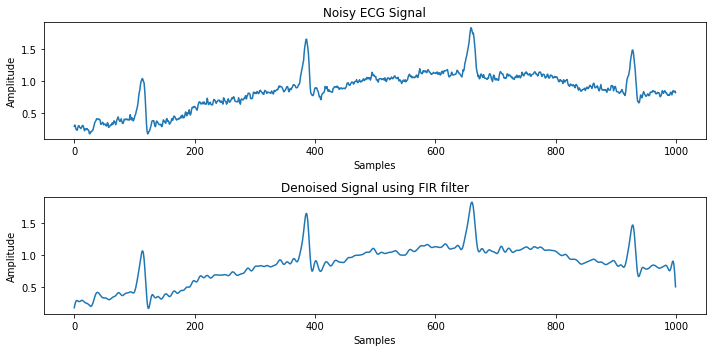

snr of original signal -11.62018682034503 db
snr of noise_added signal 8.08746942087524 db
snr of denoised signal 8.096363860776052 db
root mean square error 0.5972649427732803


In [ ]:
# FIR filter
import scipy.signal as signal

# Define filter coefficients
nyquist_freq = 100  # Hz
cutoff_freq =  20 # Hz
numtaps = 101
taps = signal.firwin(numtaps, cutoff_freq/nyquist_freq)

# Apply filter to all signals in noisy dataset
denoised_signals = []
for i in range(len(noise_bw_data)):
    denoised_signal = signal.convolve(noise_bw_data[i], taps, mode='same')
    denoised_signals.append(denoised_signal)

# Plot original and denoised signals for first signal in dataset
signal_index = 15000
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(noise_bw_data[signal_index])
plt.title('Noisy ECG Signal')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.subplot(2, 1, 2)
plt.plot(denoised_signals[signal_index])
plt.title('Denoised Signal using FIR filter')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

#testing
snr_original=0
snr_noise_added=0
snr_denoised=0
rootms=0
for i in range(20000,30000):
  output = denoised_signals[i]
  d=data[i]
  snr_original=snr_original+signaltonoise(d,n[i])
  snr_noise_added=snr_noise_added+signaltonoise(noise_bw_data[i],n[i])
  snr_denoised=snr_denoised+signaltonoise(output,output-d)
  rootms=rootms+rmse(d,output)
snr_original=snr_original/10000
snr_noise_added=snr_noise_added/10000
snr_denoised=snr_denoised/10000
rootms=rootms/10000
print('snr of original signal {} db'.format(snr_original))
print('snr of noise_added signal {} db'.format(snr_noise_added))
print('snr of denoised signal {} db'.format(snr_denoised))
print('root mean square error {}'.format(rootms))

In [ ]:
pip install pyfda

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 597.6/597.6 KB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 82.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.0/89.0 KB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.8/357.8 KB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 MB 16.5 MB/s eta 0:00:00
  Created wheel for mplcursors: filename=mplcursors-0.5.2-py3-none-any.whl size=21071 sha256=1e009c021e8c1e9e4825061c4e4ffdbf269d0d6cb9478e04703cb2b751f3cc5f
  Stored in directory: /root/.cache/pip/wheels/b1/98/ff/4885c231adf3d185efdc38cf8aa2527f1b255ca714a43cb125
Successfully built mplcursors


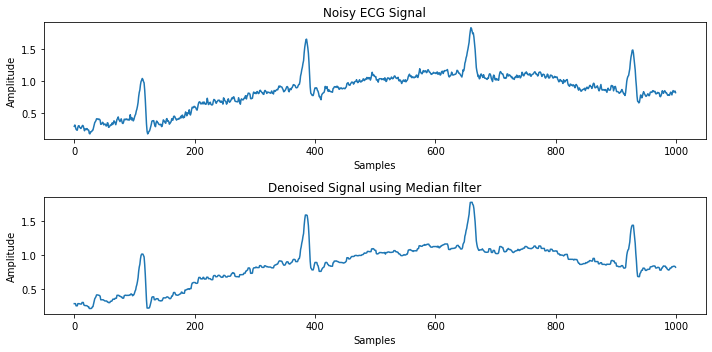

snr of original signal -11.62018682034503 db
snr of noise_added signal 8.08746942087524 db
snr of denoised signal 8.088622066868144 db
root mean square error 0.5976984568941721


In [ ]:
# Median filter
from scipy.signal import medfilt

# Define the window size of the median filter
window_size = 5

# Initialize list to store denoised signals
denoised_signals = []

# Apply median filter to all signals in noisy dataset
for i in range(len(noise_bw_data)):
    x = noise_bw_data[i]
    y = medfilt(x, kernel_size=window_size)
    denoised_signals.append(y)

# Plot original and denoised signals for first signal in dataset
signal_index = 15000
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(noise_bw_data[signal_index])
plt.title('Noisy ECG Signal')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.subplot(2, 1, 2)
plt.plot(denoised_signals[signal_index])
plt.title('Denoised Signal using Median filter')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

#testing
snr_original=0
snr_noise_added=0
snr_denoised=0
rootms=0
for i in range(20000,30000):
  output = denoised_signals[i]
  d=data[i]
  snr_original=snr_original+signaltonoise(d,n[i])
  snr_noise_added=snr_noise_added+signaltonoise(noise_bw_data[i],n[i])
  snr_denoised=snr_denoised+signaltonoise(output,output-d)
  rootms=rootms+rmse(d,output)
snr_original=snr_original/10000
snr_noise_added=snr_noise_added/10000
snr_denoised=snr_denoised/10000
rootms=rootms/10000
print('snr of original signal {} db'.format(snr_original))
print('snr of noise_added signal {} db'.format(snr_noise_added))
print('snr of denoised signal {} db'.format(snr_denoised))
print('root mean square error {}'.format(rootms))